In [1]:
filt_prefix = "filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/"
config_f = "parameters/mttrace/aggregate_qc.yaml"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import dirname, join
from src.utils.parse_config import read_config_file
import matplotlib as mpl
mpl.use('Agg')
from src.config import ROOT_DIR
from src.utils.data_io import add_id_to_sparse
import os
import numpy as np
%load_ext autoreload
%autoreload 2

Project Directory: /data2/mito_lineage


In [3]:
from src.utils.data_io import load_mtx_df
from mplh.fig_utils import helper_save as hs
from mplh.fig_utils import facet_utils as fu
from os.path import exists

In [5]:
os.chdir(ROOT_DIR)

In [6]:
config = read_config_file(config_f)

In [7]:
allConfig = {}
for c in config["configfiles"]:
    allConfig[c] = read_config_file(config["configfiles"][c])



In [8]:
output = f"{config['results']}/10x_out/10x_qcAll.png"
outdir = f"{config['results']}/10x_out/"
output

'output/mttrace/figures/QC/10x_out/10x_qcAll.png'

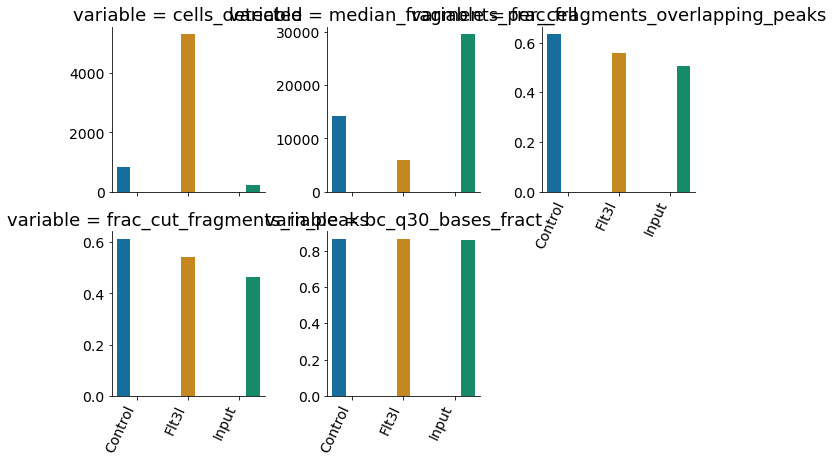

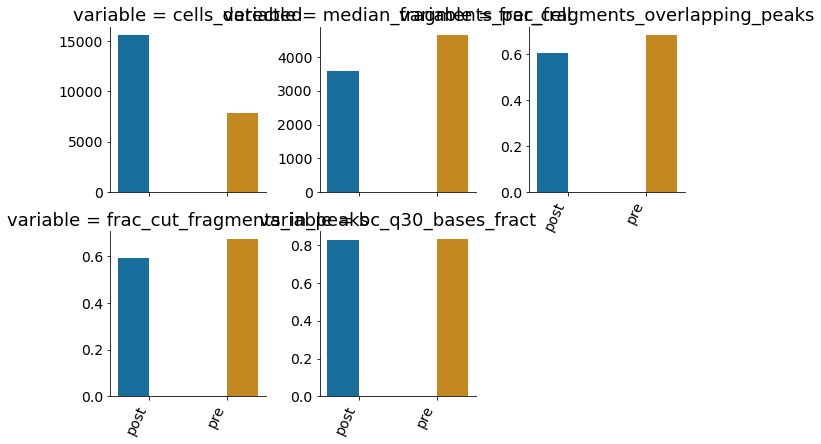

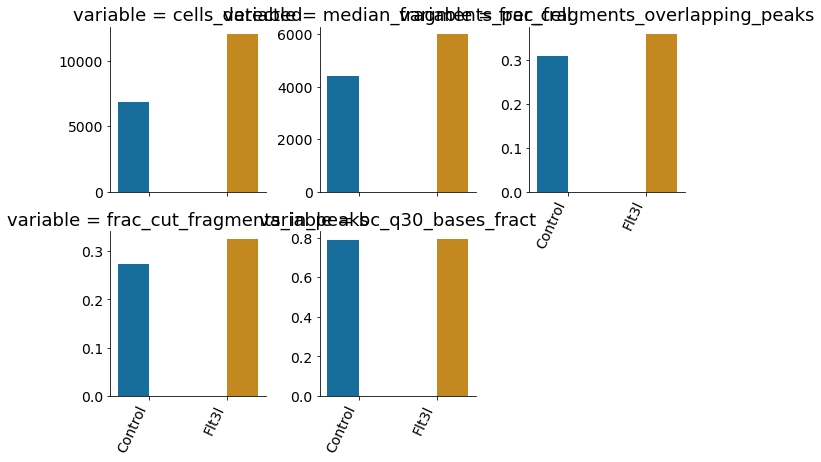

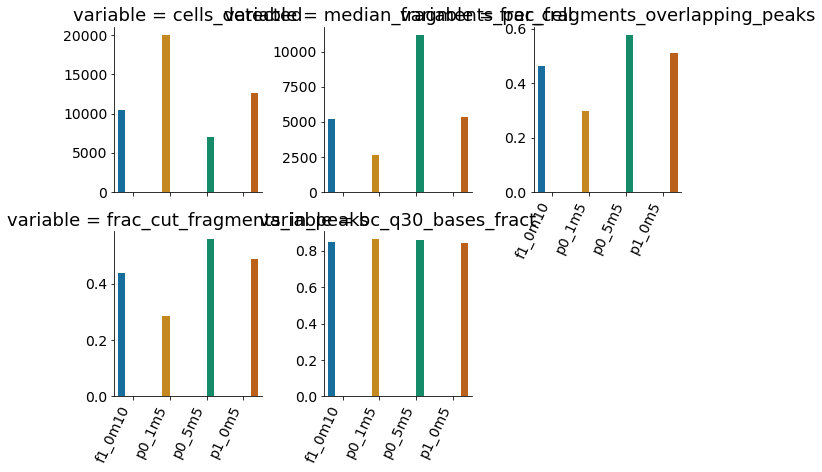

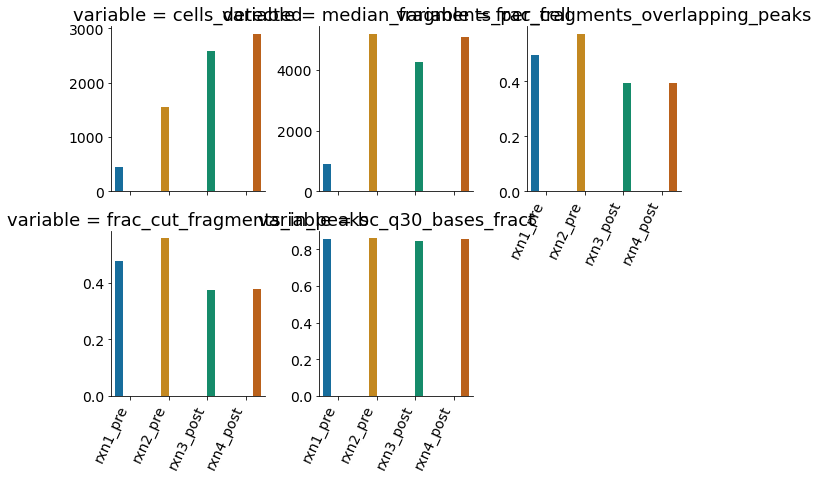

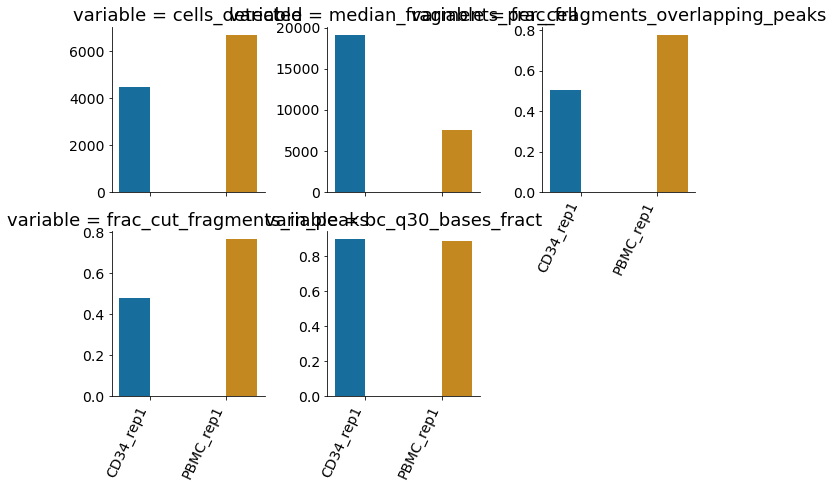

In [9]:
%matplotlib inline
all_samples = pd.DataFrame()
cols = ["cells_detected", "median_fragments_per_cell",
            "frac_fragments_overlapping_peaks",
            "frac_cut_fragments_in_peaks",
            "bc_q30_bases_fract"]
for curr in config["configfiles"]:
    curr_cfg = read_config_file(config["configfiles"][curr])
    samples = pd.read_table(curr_cfg["samples"],sep=',', index_col=0).reset_index().set_index("out_name", drop=False)
    samples = samples.dropna(axis=1)
    for ind, val in samples.iterrows():
        samples.at[ind,'metrics'] = join(dirname(val['bam_f']),"summary.csv")
    for ind, val in samples.iterrows():
        df = pd.read_csv(val["metrics"])
        df.index = [ind]
        df.index.name = "sample"
        if df.columns[0] in samples.columns:
            samples.loc[ind, df.columns] = df.loc[ind]
        else:
            samples = samples.merge(df, how='outer', left_index=True, right_index=True)

    samples = samples.drop(labels=["bam_f", "metrics"], axis=1)
    samples_long = samples.reset_index().melt(id_vars="out_name", value_vars=cols)
    g = sns.FacetGrid(data=samples_long, col="variable", sharey=False, col_wrap=3, )
    g.map_dataframe(sns.barplot, x="out_name", y="value", hue="out_name", palette="colorblind")

    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for axes in g.axes.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')
    plt.savefig(join(outdir, f"10x_qc_{curr}.png"))
#    plt.close(g)
    all_samples  = pd.concat((all_samples , samples))
    all_samples.loc[samples.index, "data"] = curr



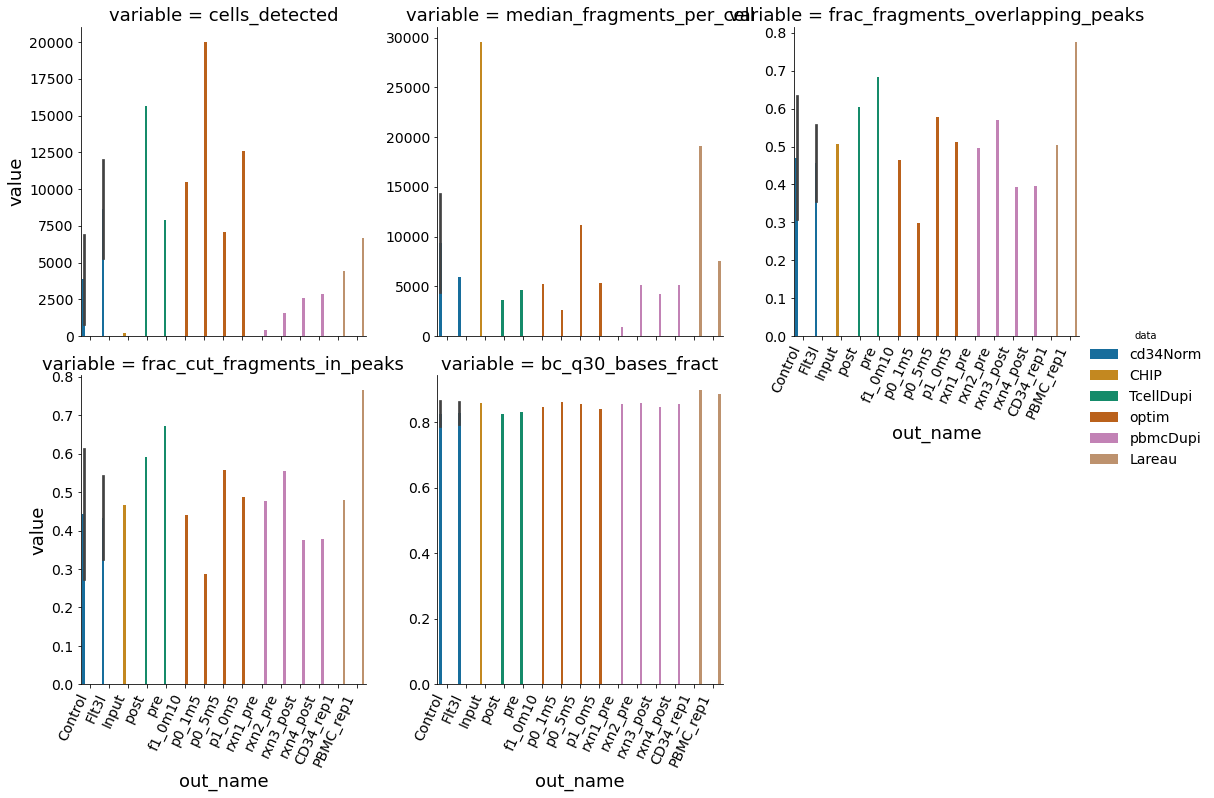

In [10]:
%matplotlib inline
all_samples_long = all_samples.reset_index().melt(id_vars=["out_name", "data"], value_vars=cols)
all_samples_long = all_samples_long.dropna(axis=0)
all_samples_long["data"] = all_samples_long["data"].astype(str)

g = sns.catplot(x="out_name", y="value", col="variable", hue="data",
           data=all_samples_long, kind='bar', col_wrap=3,
   sharey=False, palette="colorblind")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

plt.savefig(output[0])



# (TODO) Total number of fragments after removing low cell count

# Calculate Peaks per cells
And FRIP

In [11]:
allPeaksPerCell = pd.DataFrame()

for c in allConfig:
    curr_in = allConfig[c]["results"]
    mttrace_in = allConfig[c]["mttrace"]
    print(curr_in)
    samples = pd.read_table(allConfig[c]["samples"],sep=',', index_col=0).reset_index().set_index("out_name", drop=False)

    for s, df in samples.iterrows():
        print(c, s)
        peaks = pd.read_csv(join(dirname(samples.loc[s, "barcode_f"]), "peaks.bed"), sep='\t', 
                   header=None)
        cells = pd.read_csv(join(dirname(samples.loc[s, "barcode_f"]), "barcodes.tsv"), header=None)[0]
        cells = cells + "_" + s + "_" + c
        cells.index += 1 #1-based map
        mtx = load_mtx_df(join(dirname(samples.loc[s, "barcode_f"]), "matrix.mtx"), sep=' ', )
        mtx["Sample"] = s
        mtx["exp"] = c        
        mtx = add_id_to_sparse(mtx, cell=cells.to_dict(), cell_col="Cell", cell_name="BC")
        frags_in_peaks_per_cell = mtx.groupby("BC")["Variant"].sum()
        peaks_per_cell = mtx.groupby("BC").apply(lambda x: len(x["Variant"].unique()))
        peaks_per_cell = pd.DataFrame(peaks_per_cell,columns=["Number of peaks"]).pipe(lambda x: x.assign(exp = c,Sample=s))
        peaks_per_cell["Total counts"] = frags_in_peaks_per_cell
        
        allPeaksPerCell = pd.concat((allPeaksPerCell, peaks_per_cell))


output/mttrace/CHIP_april08_2021/MTblacklist
CHIP Control
CHIP Flt3l
CHIP Input
data/processed/mttrace/TcellDupi_may17_2021/MTblacklist
TcellDupi pre
TcellDupi post
data/processed/mttrace/jan21_2021/MTblacklist
cd34Norm Control
cd34Norm Flt3l
output/mttrace/optim_june03_2021/MTblacklist
optim p0_1m5
optim p0_5m5
optim p1_0m5
optim f1_0m10
data/processed/mttrace/DUPI_april08_2021_Croker
pbmcDupi rxn1_pre
pbmcDupi rxn2_pre
pbmcDupi rxn3_post
pbmcDupi rxn4_post
data/processed/mttrace/Lareau_2020/MTblacklist
Lareau CD34_rep1
Lareau PBMC_rep1


In [12]:
allPeaksPerCell["log 2 number of peaks"] = np.log2(allPeaksPerCell["Number of peaks"])
allPeaksPerCell["log 2 Total counts"] = np.log2(allPeaksPerCell["Number of peaks"])

#allPeaksPerCell["dummy"] = 1

allPeaksPerCell["ID"] = allPeaksPerCell["Sample"]+"_"+allPeaksPerCell["exp"]
allPeaksPerCell


,Number of peaks,exp,Sample,Total counts,log 2 number of peaks,log 2 Total counts,ID
BC,,,,,,,
AAACGAATCTTACTCA-1_Control_CHIP,195,CHIP,Control,11483147,7.607330,7.607330,Control_CHIP
AAACTCGAGTGGTGTG-1_Control_CHIP,380,CHIP,Control,21531966,8.569856,8.569856,Control_CHIP
AAACTCGTCAATGCAC-1_Control_CHIP,972,CHIP,Control,52897876,9.924813,9.924813,Control_CHIP
AAACTGCTCTCGCGGA-1_Control_CHIP,14849,CHIP,Control,837077968,13.858078,13.858078,Control_CHIP
AAAGATGAGCGCATTT-1_Control_CHIP,360,CHIP,Control,20298170,8.491853,8.491853,Control_CHIP
...,...,...,...,...,...,...,...
TTTGTGTGTTCTACCC-1_PBMC_rep1_Lareau,4554,Lareau,PBMC_rep1,342116412,12.152919,12.152919,PBMC_rep1_Lareau
TTTGTGTTCACCACAA-1_PBMC_rep1_Lareau,5279,Lareau,PBMC_rep1,385730155,12.366049,12.366049,PBMC_rep1_Lareau
TTTGTGTTCGGGTCCA-1_PBMC_rep1_Lareau,635,Lareau,PBMC_rep1,44548302,9.310613,9.310613,PBMC_rep1_Lareau


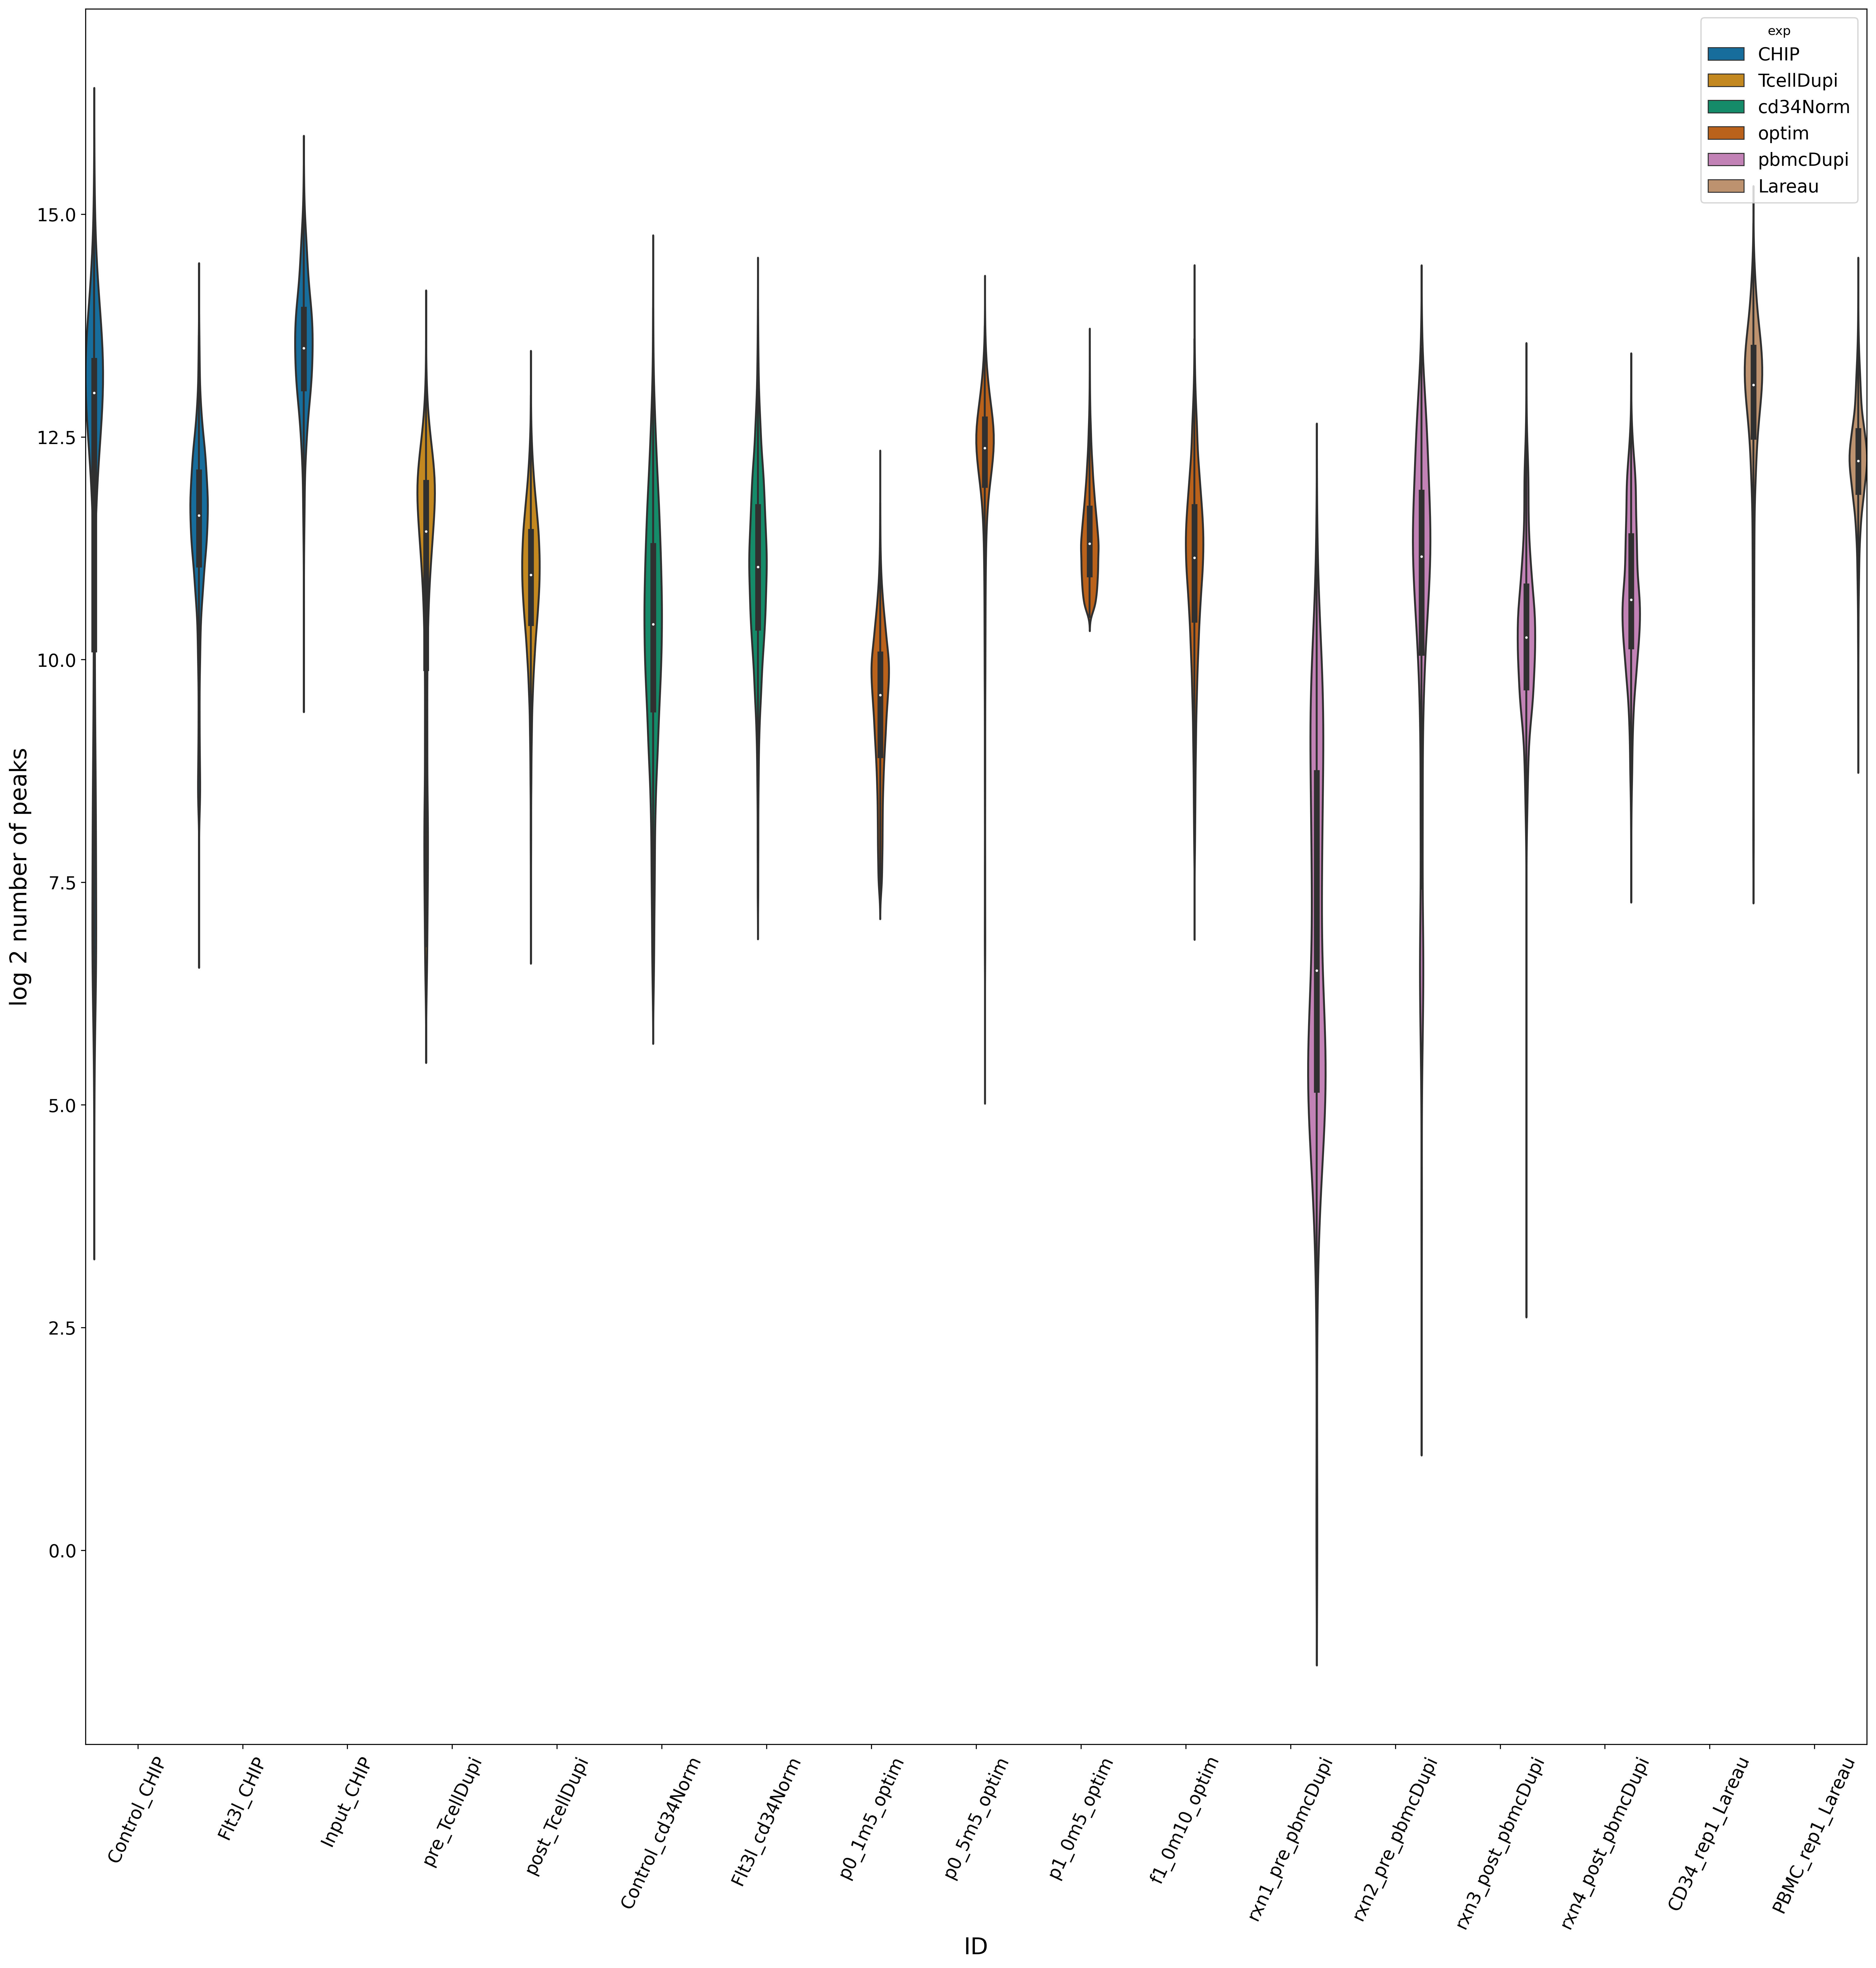

In [13]:
#f, ax = plt.subplots(figsize=(50,50))
%matplotlib inline
f, ax = plt.subplots(figsize=(25,25), dpi=300)
sns.violinplot(x="ID", y="log 2 number of peaks", hue="exp",
               data=allPeaksPerCell, palette="colorblind", width=1, figsize=(25,20))#, ax=ax)
plt.xticks(rotation=65);
# for axes in g.axes.flat:
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

# Plot MT
## VMR per cell and coverage

In [14]:
covDir_dict = {"TcellDupi":"data/processed/mttrace/PBMC_may17_2021/MTblacklist"}

## Load the coverage files

In [ ]:
# #######################
# ## coverage for initial 10x cells plus 200 MT reads filter
# #######################
# allCoverage = pd.DataFrame()
# allCoverage_d = {}

# for c in allConfig:
#     print(c)
#     for s in allConfig[c]["multiplex"]["samples"]:
#         f_in_data = join(allConfig[c]["results"], "data", s, 
#                              "MT","cellr_True", f"{s}_200", 
#                              f"{s}.coverage.strands.txt.gz")
#         f_in = join(allConfig[c]["results"], s, "MT","cellr_True", f"{s}_200", 
#                                  f"{s}.coverage.strands.txt.gz")
#         if "old_results" in allConfig[c]:
#             f_in_old = join(allConfig[c]["old_results"], s, 
#                                      "MT","cellr_True", f"{s}_200", 
#                                      f"{s}.coverage.strands.txt.gz")
#         else:
#             f_in_old = ""
            
#         if c in covDir_dict:
#             f_in_covDir_dict = join(covDir_dict[c], s, 
#                                      "MT","cellr_True", f"{s}_200", 
#                                      f"{s}.coverage.strands.txt.gz")
#         else:
#             f_in_covDir_dict = ""
#         does_exist=False
#         for f in [f_in, f_in_data, f_in_covDir_dict, f_in_old]:
#             if exists(f):
#                 print(f"Reading {f}")
#                 curr_coverage = pd.read_csv(f, header=None)
#                 does_exist=True
#                 # Add info to cell ids in case of duplicates
#                 curr_coverage[1] = curr_coverage[1]+"_"+s+"_"+c
#                 allCoverage_d[(c,s)] = curr_coverage
                
#         if not does_exist:
#             print(f"File for {c}, {s} not here")
#             continue            
                
        
# allCoverage = pd.concat(allCoverage_d).reset_index().rename({0:"Pos", 1:"Cell", 2:"Count", "level_0":"exp", "level_1":"Sample"}, axis=1)
# allCoverage

CHIP
Reading output/mttrace/CHIP_april08_2021/MTblacklist/data/Control/MT/cellr_True/Control_200/Control.coverage.strands.txt.gz
Reading data/processed/mttrace/CHIP_april08_2021/MTblacklist/Control/MT/cellr_True/Control_200/Control.coverage.strands.txt.gz
Reading data/processed/mttrace/CHIP_april08_2021/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/Flt3l.coverage.strands.txt.gz
Reading output/mttrace/CHIP_april08_2021/MTblacklist/data/Input/MT/cellr_True/Input_200/Input.coverage.strands.txt.gz
Reading data/processed/mttrace/CHIP_april08_2021/MTblacklist/Input/MT/cellr_True/Input_200/Input.coverage.strands.txt.gz
TcellDupi
Reading data/processed/mttrace/PBMC_may17_2021/MTblacklist/pre/MT/cellr_True/pre_200/pre.coverage.strands.txt.gz
Reading data/processed/mttrace/PBMC_may17_2021/MTblacklist/post/MT/cellr_True/post_200/post.coverage.strands.txt.gz
cd34Norm
File for cd34Norm, P2 not here
File for cd34Norm, J2 not here
optim
File for optim, p0_1m5 not here
File for optim, p0_5m5 not here
File

In [15]:
#######################
## coverage for filtered cells by allele depth, position counts and cell counts
#######################
allCoverage = pd.DataFrame()
allCoverage_d = {}

for c in allConfig:
    print(c)
    for s in allConfig[c]["multiplex"]["samples"]:
        f_in_data = join(allConfig[c]["results"], "data", s, "MT","cellr_True", f"{s}_200",
                         filt_prefix, f"{s}.coverage.txt")
        f_in = join(allConfig[c]["results"], s, filt_prefix, f"{s}.coverage.txt")
        if "old_results" in allConfig[c]:
            f_in_old = join(allConfig[c]["old_results"], s, "MT","cellr_True", f"{s}_200", 
                            filt_prefix, f"{s}.coverage.txt") 
        else:
            f_in_old = ""
            
        if c in covDir_dict:
            f_in_covDir_dict = join(covDir_dict[c], s, filt_prefix, f"{s}.coverage.txt")
                                     
        else:
            f_in_covDir_dict = ""
        does_exist=False
        for f in [f_in, f_in_data, f_in_covDir_dict, f_in_old]:
            if exists(f):
                print(f"Reading {f}")
                curr_coverage = pd.read_csv(f, header=None)
                does_exist=True
                # Add info to cell ids in case of duplicates
                curr_coverage[1] = curr_coverage[1]+"_"+s+"_"+c
                allCoverage_d[(c,s)] = curr_coverage
                
        if not does_exist:
            print(f"File for {c}, {s} not here")
            continue            
                
        
allCoverage = pd.concat(allCoverage_d).reset_index().rename({0:"Pos", 1:"Cell", 2:"Count", "level_0":"exp", "level_1":"Sample"}, axis=1)
allCoverage

CHIP
Reading data/processed/mttrace/CHIP_april08_2021/MTblacklist/Control/MT/cellr_True/Control_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/Control.coverage.txt
Reading data/processed/mttrace/CHIP_april08_2021/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/Flt3l.coverage.txt
Reading output/mttrace/CHIP_april08_2021/MTblacklist/data/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/Input.coverage.txt
Reading data/processed/mttrace/CHIP_april08_2021/MTblacklist/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/Input.coverage.txt
TcellDupi
Reading data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/pre/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/pre.coverage.txt
Reading data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/post.coverage.txt
cd34Norm
F

,exp,Sample,level_2,Pos,Cell,Count
0,CHIP,Control,0,34,AAACTGCTCTCGCGGA-1_Control_CHIP,995
1,CHIP,Control,1,62,AAACTGCTCTCGCGGA-1_Control_CHIP,1114
2,CHIP,Control,2,68,AAACTGCTCTCGCGGA-1_Control_CHIP,1168
3,CHIP,Control,3,69,AAACTGCTCTCGCGGA-1_Control_CHIP,1179
4,CHIP,Control,4,73,AAACTGCTCTCGCGGA-1_Control_CHIP,1265
...,...,...,...,...,...,...
8980562,pbmcDupi,rxn4,223918,16295,TTTGTGTTCCATGACA-1_rxn4_pbmcDupi,66
8980563,pbmcDupi,rxn4,223919,16319,TTTGTGTTCCATGACA-1_rxn4_pbmcDupi,29
8980564,pbmcDupi,rxn4,223920,16362,TTTGTGTTCCATGACA-1_rxn4_pbmcDupi,49
8980565,pbmcDupi,rxn4,223921,16483,TTTGTGTTCCATGACA-1_rxn4_pbmcDupi,74


In [16]:
cell_mean = allCoverage.groupby(["Cell", "Sample", "exp"])["Count"].mean()
cell_var = allCoverage.groupby(["Cell", "Sample", "exp"])["Count"].var()
cell_vmr = cell_var/cell_mean

In [17]:
cell_sum = allCoverage.groupby(["Cell", "Sample", "exp"])["Count"].sum()

                                Cell   Sample        exp      Mean        VMR  \
0  AAACGAAAGAACAGGA-1_post_TcellDupi     post  TcellDupi  5.694631   5.398118   
1   AAACGAAAGACCGCAA-1_f1_0m10_optim  f1_0m10      optim  6.391292  10.360495   
2   AAACGAAAGACTCGGA-1_f1_0m10_optim  f1_0m10      optim  5.310036  10.500125   
3   AAACGAAAGAGCAGCT-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.761389   7.221412   
4   AAACGAAAGAGCTACG-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.582394   6.133955   

      MT Sum              ID  
0  13.760720  post_TcellDupi  
1  12.457381   f1_0m10_optim  
2  11.376125   f1_0m10_optim  
3  12.118941   rxn4_pbmcDupi  
4  11.939946   rxn4_pbmcDupi  


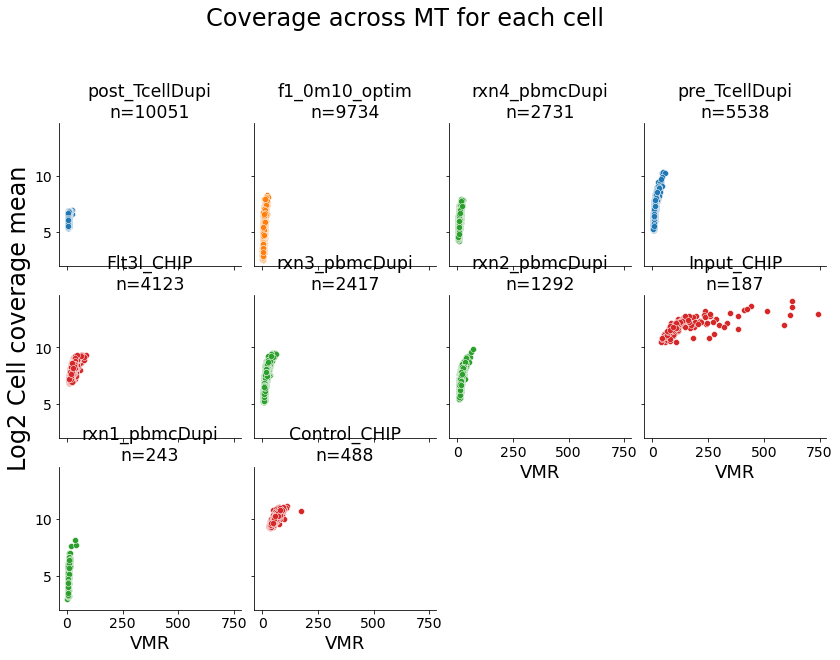

In [19]:
%matplotlib inline
cell_df = pd.concat((np.log2(cell_mean.rename("Mean")), 
                     cell_vmr.rename("VMR"), np.log2(cell_sum.rename("MT Sum"))), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
cell_df["ID"] = cell_df["Sample"]+"_"+cell_df["exp"]
#sns.scatterplot(data=cell_df, x="VMR", y="Mean", hue="exp")
g = sns.FacetGrid(data=cell_df,col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.scatterplot, x="VMR", y="Mean")
g.set_axis_labels("VMR", "Log2 Cell coverage mean")
g = fu(g, cell_df, sup_ylabel="Log2 Cell coverage mean", 
                sup_title="Coverage across MT for each cell", title_add_n=True)

#g.fig.subplots_adjust(top=0.9)
#g.fig.suptitle("Coverage across MT for each cell")
#cell_df

                                Cell   Sample        exp      Mean       VMR  \
0  AAACGAAAGAACAGGA-1_post_TcellDupi     post  TcellDupi  5.694631  2.432456   
1   AAACGAAAGACCGCAA-1_f1_0m10_optim  f1_0m10      optim  6.391292  3.373021   
2   AAACGAAAGACTCGGA-1_f1_0m10_optim  f1_0m10      optim  5.310036  3.392335   
3   AAACGAAAGAGCAGCT-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.761389  2.852281   
4   AAACGAAAGAGCTACG-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.582394  2.616818   

      MT Sum              ID  
0  13.760720  post_TcellDupi  
1  12.457381   f1_0m10_optim  
2  11.376125   f1_0m10_optim  
3  12.118941   rxn4_pbmcDupi  
4  11.939946   rxn4_pbmcDupi  


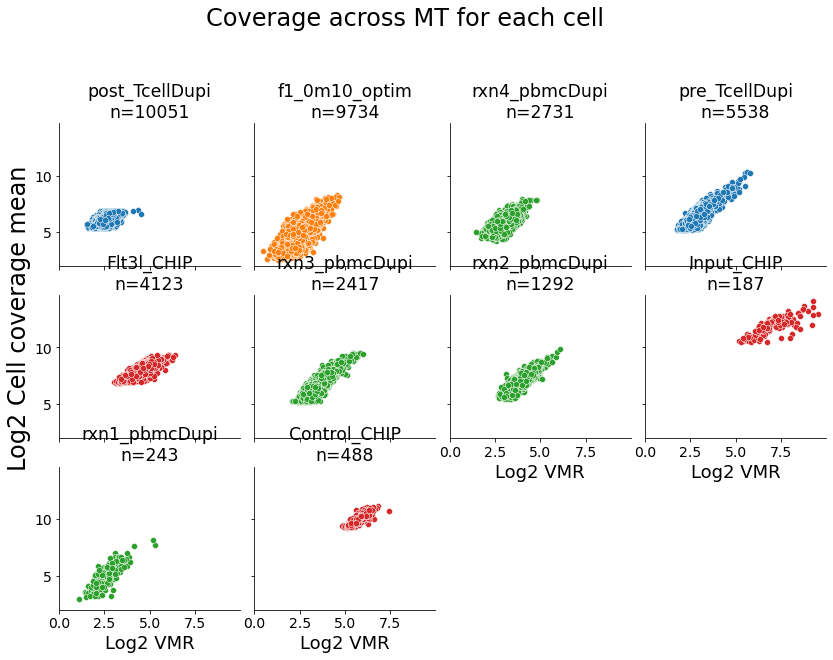

In [27]:
%matplotlib inline
cell_df = pd.concat((np.log2(cell_mean.rename("Mean")), 
                     np.log2(cell_vmr.rename("VMR")),
                     np.log2(cell_sum.rename("MT Sum"))), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
cell_df["ID"] = cell_df["Sample"]+"_"+cell_df["exp"]
#sns.scatterplot(data=cell_df, x="VMR", y="Mean", hue="exp")
g = sns.FacetGrid(data=cell_df,col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.scatterplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 Cell coverage mean")
g = fu(g, cell_df, sup_ylabel="Log2 Cell coverage mean", 
                sup_title="Coverage across MT for each cell", title_add_n=True)


                                Cell   Sample        exp      Mean       VMR  \
0  AAACGAAAGAACAGGA-1_post_TcellDupi     post  TcellDupi  5.694631  2.432456   
1   AAACGAAAGACCGCAA-1_f1_0m10_optim  f1_0m10      optim  6.391292  3.373021   
2   AAACGAAAGACTCGGA-1_f1_0m10_optim  f1_0m10      optim  5.310036  3.392335   
3   AAACGAAAGAGCAGCT-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.761389  2.852281   
4   AAACGAAAGAGCTACG-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.582394  2.616818   

      MT Sum              ID  
0  13.760720  post_TcellDupi  
1  12.457381   f1_0m10_optim  
2  11.376125   f1_0m10_optim  
3  12.118941   rxn4_pbmcDupi  
4  11.939946   rxn4_pbmcDupi  


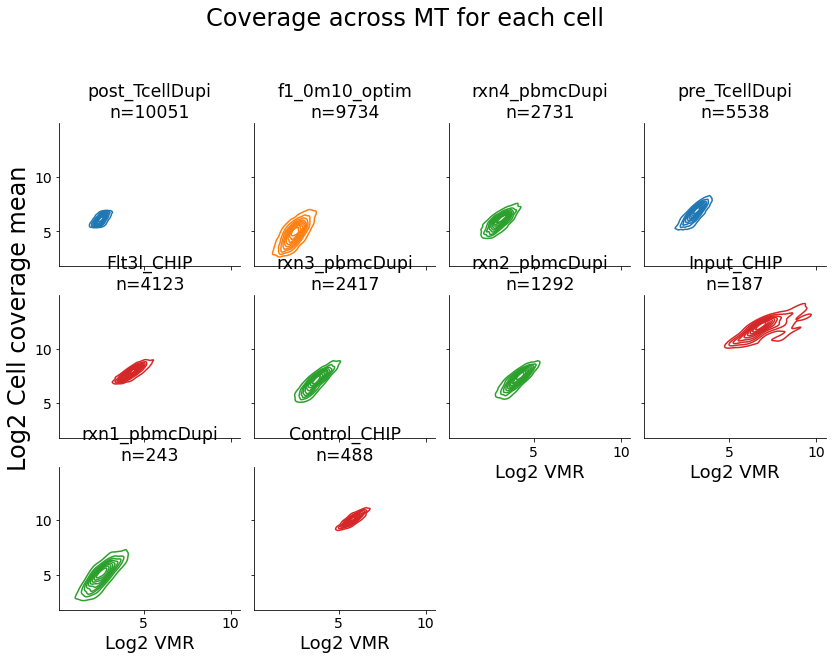

In [28]:
%matplotlib inline
g = sns.FacetGrid(data=cell_df,col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 Cell coverage mean")
g = fu(g, cell_df, sup_ylabel="Log2 Cell coverage mean", 
                sup_title="Coverage across MT for each cell", title_add_n=True)


In [29]:
pos_mean = allCoverage.groupby(["Pos", "Sample", "exp"])["Count"].mean()
pos_var = allCoverage.groupby(["Pos", "Sample", "exp"])["Count"].var()
pos_vmr = pos_var/pos_mean

pos_df = pd.concat((np.log2(pos_mean.rename("Mean")), np.log2(pos_vmr.rename("VMR"))), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
pos_df["ID"] = pos_df["Sample"]+"_"+pos_df["exp"]



   Pos   Sample        exp       Mean        VMR              ID
0   28    Input       CHIP  11.779983  10.189935      Input_CHIP
1   34  Control       CHIP   9.868317   6.811777    Control_CHIP
2   42    Input       CHIP  12.012436  10.390491      Input_CHIP
3   49    Input       CHIP  12.020139  10.385966      Input_CHIP
4   49     post  TcellDupi   6.119888   3.242476  post_TcellDupi


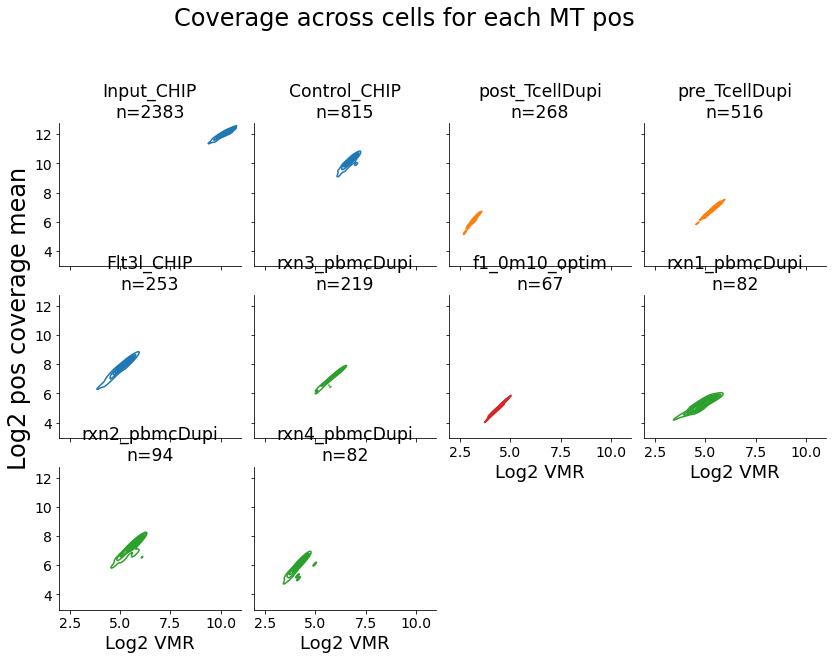

In [30]:
%matplotlib inline
g = sns.FacetGrid(data=pos_df,col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 pos coverage mean")
g = fu(g, pos_df, sup_ylabel="Log2 pos coverage mean", 
                sup_title="Coverage across cells for each MT pos", title_add_n=True)


   Pos   Sample        exp       Mean        VMR              ID
0   28    Input       CHIP  11.779983  10.189935      Input_CHIP
1   34  Control       CHIP   9.868317   6.811777    Control_CHIP
2   42    Input       CHIP  12.012436  10.390491      Input_CHIP
3   49    Input       CHIP  12.020139  10.385966      Input_CHIP
4   49     post  TcellDupi   6.119888   3.242476  post_TcellDupi


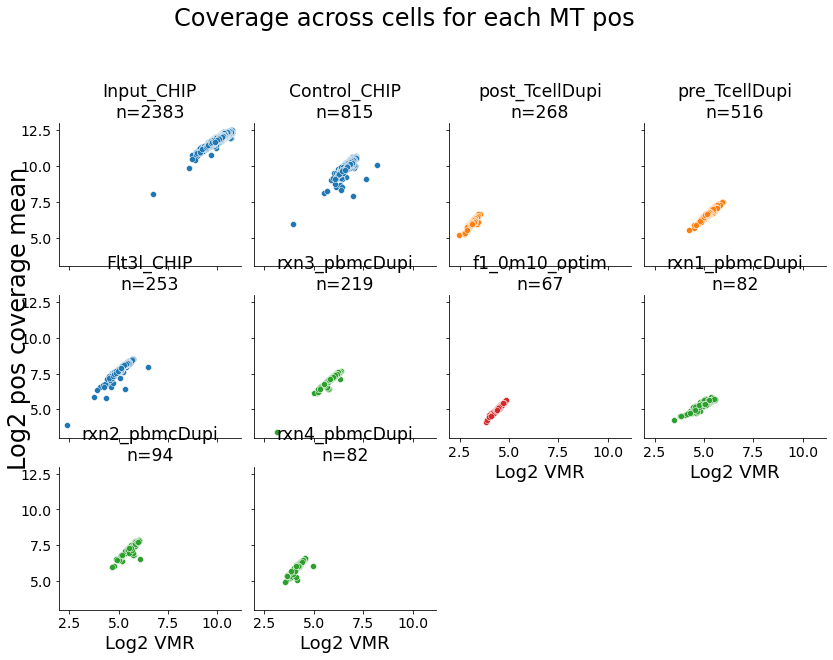

In [31]:
%matplotlib inline
pos_df = pd.concat((np.log2(pos_mean.rename("Mean")), np.log2(pos_vmr.rename("VMR"))), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
pos_df["ID"] = pos_df["Sample"]+"_"+pos_df["exp"]
#sns.scatterplot(data=pos_df, x="VMR", y="Mean", hue="exp")
g = sns.FacetGrid(data=pos_df,col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.scatterplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 pos coverage mean")
g = fu(g, pos_df, sup_ylabel="Log2 pos coverage mean", 
                sup_title="Coverage across cells for each MT pos", title_add_n=True)


# Plot MT coverage /number of nuclear fragments for each cell

## Merge the nuclear cell counts and nuclear fragments 

In [32]:
cells_merge_filt__peaks = pd.merge(cell_df, allPeaksPerCell.reset_index().rename({"BC":"Cell"}, axis=1),
                                   on=["Cell", "Sample", "exp", "ID"], how="inner")
cells_merge_filt__peaks

,Cell,Sample,exp,Mean,VMR,MT Sum,ID,Number of peaks,Total counts,log 2 number of peaks,log 2 Total counts
0,AAACGAAAGAACAGGA-1_post_TcellDupi,post,TcellDupi,5.694631,2.432456,13.760720,post_TcellDupi,575,20665379,9.167418,9.167418
1,AAACGAAAGACCGCAA-1_f1_0m10_optim,f1_0m10,optim,6.391292,3.373021,12.457381,f1_0m10_optim,9593,316459799,13.227766,13.227766
2,AAACGAAAGACTCGGA-1_f1_0m10_optim,f1_0m10,optim,5.310036,3.392335,11.376125,f1_0m10_optim,2201,74652125,11.103943,11.103943
3,AAACGAAAGAGCTCCC-1_f1_0m10_optim,f1_0m10,optim,4.914764,2.005759,10.980854,f1_0m10_optim,933,32152358,9.865733,9.865733
4,AAACGAAAGATTGACA-1_post_TcellDupi,post,TcellDupi,6.001009,2.450286,14.067098,post_TcellDupi,1319,50134908,10.365229,10.365229
...,...,...,...,...,...,...,...,...,...,...,...
30116,TTTGTGTTCGGATGTT-1_post_TcellDupi,post,TcellDupi,6.128668,2.268687,14.194757,post_TcellDupi,1458,53083086,10.509775,10.509775
30117,TTTGTGTTCTTAATCC-1_post_TcellDupi,post,TcellDupi,5.535101,1.877859,13.601190,post_TcellDupi,2680,97624108,11.388017,11.388017
30118,TTTGTGTTCTTATCAC-1_f1_0m10_optim,f1_0m10,optim,5.412175,2.652143,11.478264,f1_0m10_optim,1765,56647340,10.785452,10.785452
30119,TTTGTGTTCTTCTTCC-1_Flt3l_CHIP,Flt3l,CHIP,7.658042,3.982615,15.641036,Flt3l_CHIP,3390,300430041,11.727070,11.727070


                                Cell   Sample        exp      Mean       VMR  \
0  AAACGAAAGAACAGGA-1_post_TcellDupi     post  TcellDupi  5.694631  2.432456   
1   AAACGAAAGACCGCAA-1_f1_0m10_optim  f1_0m10      optim  6.391292  3.373021   
2   AAACGAAAGACTCGGA-1_f1_0m10_optim  f1_0m10      optim  5.310036  3.392335   
3   AAACGAAAGAGCAGCT-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.761389  2.852281   
4   AAACGAAAGAGCTACG-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.582394  2.616818   

      MT Sum              ID  
0  13.760720  post_TcellDupi  
1  12.457381   f1_0m10_optim  
2  11.376125   f1_0m10_optim  
3  12.118941   rxn4_pbmcDupi  
4  11.939946   rxn4_pbmcDupi  


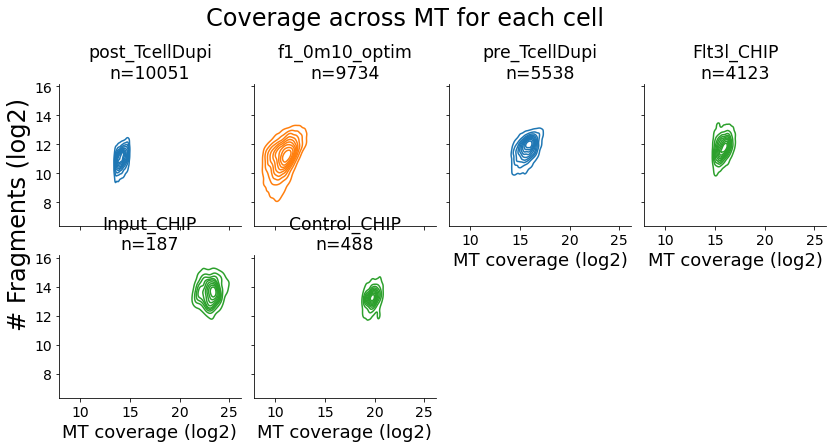

In [33]:
%matplotlib inline
g = sns.FacetGrid(data=cells_merge_filt__peaks, 
                  col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.kdeplot, x="MT Sum", y="log 2 Total counts")
g.set_axis_labels("MT coverage (log2)", "# Fragments (log2)")
g = fu(g, cell_df, sup_ylabel="# Fragments (log2)", 
                sup_title="Coverage across MT for each cell", title_add_n=True)


                                Cell   Sample        exp      Mean       VMR  \
0  AAACGAAAGAACAGGA-1_post_TcellDupi     post  TcellDupi  5.694631  2.432456   
1   AAACGAAAGACCGCAA-1_f1_0m10_optim  f1_0m10      optim  6.391292  3.373021   
2   AAACGAAAGACTCGGA-1_f1_0m10_optim  f1_0m10      optim  5.310036  3.392335   
3   AAACGAAAGAGCAGCT-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.761389  2.852281   
4   AAACGAAAGAGCTACG-1_rxn4_pbmcDupi     rxn4   pbmcDupi  5.582394  2.616818   

      MT Sum              ID  
0  13.760720  post_TcellDupi  
1  12.457381   f1_0m10_optim  
2  11.376125   f1_0m10_optim  
3  12.118941   rxn4_pbmcDupi  
4  11.939946   rxn4_pbmcDupi  


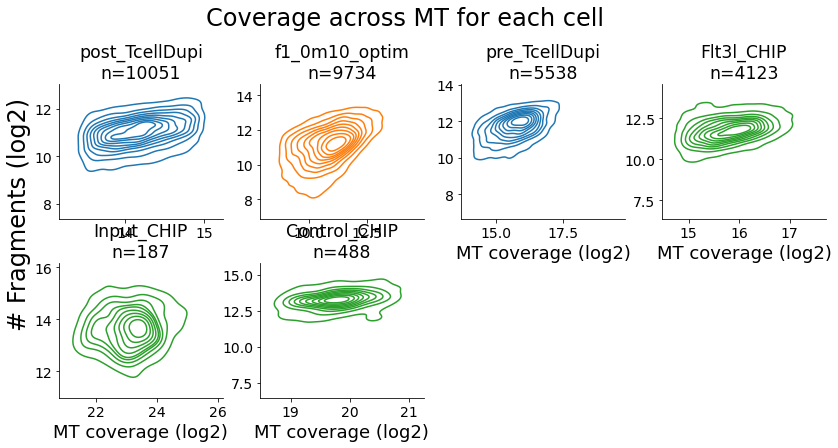

In [34]:
%matplotlib inline
g = sns.FacetGrid(data=cells_merge_filt__peaks, 
                  col_wrap=4, col="ID", hue="exp", sharex=False, sharey=False)
g.fig.subplots_adjust(hspace=0.2)
g.map_dataframe(sns.kdeplot, x="MT Sum", y="log 2 Total counts")
g.set_axis_labels("MT coverage (log2)", "# Fragments (log2)")
g = fu(g, cell_df, sup_ylabel="# Fragments (log2)", 
                sup_title="Coverage across MT for each cell", title_add_n=True)


## lineplot

In [170]:
# %matplotlib inline
# g = sns.FacetGrid(data=pos_df,col_wrap=4, col="ID", hue="exp")

# g.map_dataframe(sns.lineplot, x="VMR", y="Mean")
# # g.set_axis_labels("Log2 VMR", "Log2 pos coverage mean")
# # g = facet_utils(g, pos_df, sup_ylabel="Log2 pos coverage mean", 
# #                 sup_title="Coverage across cells for each MT pos", title_add_n=True)


In [57]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=36)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [58]:
def get_frag(indir):
    df = pd.read_csv(join(indir, "fragments.tsv.gz"), sep="\t")
    return


def check_frag_in_peak(frag, peaks):
    #print(((frag["Start"] <= peaks["End"]) & (frag["End"] >= peaks["Start"])).any())
    return ((frag["Start"] <= peaks["End"]) & (frag["End"] >= peaks["Start"])).any()
    

def calc_frip_per_cell(frags, peaks=None, cells=None, to_annotate=False):
    frags = (frags.copy())[frags["Cell"].isin(cells)]
    if to_annotate: 
        frags["in_peak"] = frags.parallel_apply(check_frag_in_peak,args=(peaks,), axis=1)
    cb_frags = frags.groupby("Cell")
    frags_sum = cb_frags["Count"].sum()
    #frags_in_read_sum = cb_frags.apply(lambda x: sum([x["Count"] if (x["in_peak"])]))
    frags_in_read_sum = frags.groupby("in_peak").get_group(True).groupby("Cell")["Count"].sum()
    frip = frags_in_read_sum/frags_sum
    #print(frags_sum.head())
    #print(frags_in_read_sum.head())
    #print(frip.head())
    frip_df = pd.concat((frags_sum.rename("Total frags"), frags_in_read_sum.rename("Frags in peak"), 
                         frip.rename("FRIP")), axis=1)
    return frip_df


def plot_frip_per_cell(frip_df, out_f=None):
    f, ax = plt.subplots(nrows=2, ncols=1)
    sns.violinplot(frip_df, y="frip", ax=ax[0])
    sns.scatterplot(frip_df, x="frags_sum", y="frip", ax=ax[1])
    hs(out_f)
    return

In [ ]:
frip_per_cell = {}
for c in allConfig:
    samples = pd.read_table(allConfig[c]["samples"],sep=',', index_col=0).reset_index().set_index("sample_name", drop=False)
    samples = samples.dropna(axis=1)
    for s in allConfig[c]["multiplex"]["samples"]:
        if s in samples.index:
            curr_in = dirname(samples.loc[s, "barcode_f"])
        else:
            curr_in = dirname(samples.set_index("sample").loc[s, "barcode_f"])
        print(c, s)
        curr_frags = pd.read_csv(join(dirname(curr_in), "fragments.tsv.gz"), sep="\t", header=None)
        curr_frags.columns = ["Chr", "Start", "End", "Cell", "Count"]
        curr_frags["Cell"] = curr_frags["Cell"]+"_"+s+"_"+c
        peaks = pd.read_csv(join(curr_in, "peaks.bed"), sep="\t", header=None)
        peaks = peaks.rename({0:"Chr", 1:"Start", 2:"End"}, axis=1)
        
        cells = pd.read_csv(join(curr_in, "barcodes.tsv"), header=None)[0]
        cells = cells + "_" + s + "_" + c
        cells.index += 1 #1-based map
        
        frip_per_cell[(c,s)] = calc_frip_per_cell(curr_frags, peaks, cells, to_annotate=True)
    #for s in join(dirname(samples.loc[s, "barcode_f"])

CHIP Control
CHIP Flt3l


In [62]:
frip_per_cell_df = pd.concat(frip_per_cell).reset_index().rename({"level_0":"exp", "level_1":"Sample"}, axis=1)

frip_per_cell_df["ID"] = frip_per_cell_df["exp"]+"_"+frip_per_cell_df["Sample"]
frip_per_cell_df

,exp,Sample,Cell,Total frags,Frags in peak,FRIP
0,CHIP,Control,AAACGAATCTTACTCA-1_Control_CHIP,390,261,0.669231
1,CHIP,Control,AAACTCGAGTGGTGTG-1_Control_CHIP,7459,5018,0.672744
2,CHIP,Control,AAACTCGTCAATGCAC-1_Control_CHIP,4789,3904,0.815202
3,CHIP,Control,AAACTGCTCTCGCGGA-1_Control_CHIP,104946,93740,0.893221
4,CHIP,Control,AAAGATGAGCGCATTT-1_Control_CHIP,5951,4301,0.722736
...,...,...,...,...,...,...
68750,optim,p0_1m5,TTTGTGTTCCATCTAT-1_p0_1m5_optim,5282,2376,0.449830
68751,optim,p0_1m5,TTTGTGTTCCATTGTT-1_p0_1m5_optim,2483,1211,0.487716
68752,optim,p0_1m5,TTTGTGTTCGATGTGT-1_p0_1m5_optim,4533,2406,0.530774
68753,optim,p0_1m5,TTTGTGTTCGTATAGC-1_p0_1m5_optim,6788,3098,0.456394


    exp   Sample                             Cell  Total frags  Frags in peak  \
0  CHIP  Control  AAACGAATCTTACTCA-1_Control_CHIP          390            261   
1  CHIP  Control  AAACTCGAGTGGTGTG-1_Control_CHIP         7459           5018   
2  CHIP  Control  AAACTCGTCAATGCAC-1_Control_CHIP         4789           3904   
3  CHIP  Control  AAACTGCTCTCGCGGA-1_Control_CHIP       104946          93740   
4  CHIP  Control  AAAGATGAGCGCATTT-1_Control_CHIP         5951           4301   

       FRIP            ID  
0  0.669231  CHIP_Control  
1  0.672744  CHIP_Control  
2  0.815202  CHIP_Control  
3  0.893221  CHIP_Control  
4  0.722736  CHIP_Control  


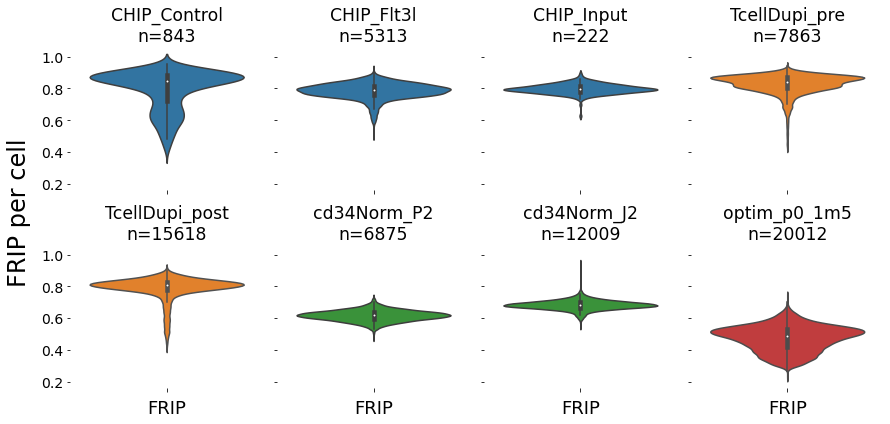

In [141]:
g = sns.FacetGrid(data=frip_per_cell_df,col_wrap=4, col="ID", hue="exp")
g.map_dataframe(sns.violinplot,  y="FRIP")
g.set_axis_labels("FRIP")
g = fu(g, frip_per_cell_df, sup_ylabel="FRIP per cell", title_add_n=True)
hs(join(outdir, "tmp_frip"))

    exp   Sample                             Cell  Total frags  Frags in peak  \
0  CHIP  Control  AAACGAATCTTACTCA-1_Control_CHIP          390            261   
1  CHIP  Control  AAACTCGAGTGGTGTG-1_Control_CHIP         7459           5018   
2  CHIP  Control  AAACTCGTCAATGCAC-1_Control_CHIP         4789           3904   
3  CHIP  Control  AAACTGCTCTCGCGGA-1_Control_CHIP       104946          93740   
4  CHIP  Control  AAAGATGAGCGCATTT-1_Control_CHIP         5951           4301   

       FRIP            ID  
0  0.669231  CHIP_Control  
1  0.672744  CHIP_Control  
2  0.815202  CHIP_Control  
3  0.893221  CHIP_Control  
4  0.722736  CHIP_Control  


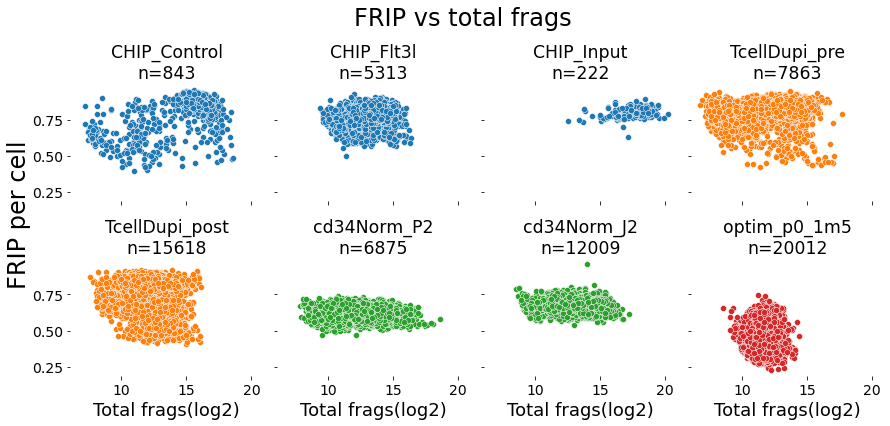

In [140]:
g = sns.FacetGrid(data=frip_per_cell_df.assign(frags_log2=lambda x: np.log2(x['Total frags'])),col_wrap=4, col="ID", hue="exp")
g.map_dataframe(sns.scatterplot, x="frags_log2", y="FRIP")
g.set_axis_labels("Total frags(log2)", "FRIP")
g = fu(g, frip_per_cell_df, sup_ylabel="FRIP per cell", title_add_n=True, sup_title="FRIP vs total frags")
hs(join(outdir, "tmp_frags_frip"))

# FRIP per cell for filters

In [ ]:
frip_per_cell = {}

for c in allConfig:
    print(c)
    for s in allConfig[c]["multiplex"]["samples"]:
        f_in_data = join(allConfig[c]["results"], "data", s, "MT","cellr_True", f"{s}_200",
                         filt_prefix, f"{s}.coverage.txt")
        f_in = join(allConfig[c]["results"], s, filt_prefix, f"{s}.coverage.txt")
        if "old_results" in allConfig[c]:
            f_in_old = join(allConfig[c]["old_results"], s, "MT","cellr_True", f"{s}_200", 
                            filt_prefix, f"{s}.coverage.txt") 
        else:
            f_in_old = ""
            
        if c in covDir_dict:
            f_in_covDir_dict = join(covDir_dict[c], s, filt_prefix, f"{s}.coverage.txt")
                                     
        else:
            f_in_covDir_dict = ""
        does_exist=False
        for f in [f_in, f_in_data, f_in_covDir_dict, f_in_old]:
            if exists(f):
                print(f"Reading {f}")
                curr_coverage = pd.read_csv(f, header=None, usecols=[1])
                does_exist=True
                # Add info to cell ids in case of duplicates
                curr_coverage[1] = curr_coverage[1]+"_"+s+"_"+c
                allCoverage_d[(c,s)] = curr_coverage
                
        if not does_exist:
            print(f"File for {c}, {s} not here")
            continue            
            
        frip_per_cell[(c,s)] = calc_frip_per_cell(curr_frags, peaks, cells, to_annotate=True)


CHIP Control
CHIP Flt3l


In [148]:
def get_filt_indir(allConfig):
    allFilt = {}
    for c in allConfig:
        print(c)
        for s in allConfig[c]["multiplex"]["samples"]:
            ###########################
            # Get filtered cell indices
            ###########################
            f_in_data = join(allConfig[c]["results"], "data", s, "MT","cellr_True", f"{s}_200",
                             filt_prefix, "af_by_cell.tsv")
            f_in = join(allConfig[c]["results"], s, filt_prefix, "af_by_cell.tsv")
            if "old_results" in allConfig[c]:
                f_in_old = join(allConfig[c]["old_results"], s, "MT","cellr_True", f"{s}_200", 
                                filt_prefix, "af_by_cell.tsv") 
            else:
                f_in_old = ""
            if c in covDir_dict:
                f_in_covDir_dict = join(covDir_dict[c], s, filt_prefix, "af_by_cell.tsv")                             
            else:
                f_in_covDir_dict = ""
            does_exist=False
            for f in [f_in, f_in_data, f_in_covDir_dict, f_in_old]:
                if exists(f):
                    print(f"Adding {f}")
                    allFilt[(c,s)] = f
                    does_exist=True
            if not does_exist:
                print(f"File for {c}, {s} not here")
                continue            
    return allFilt


def preproc_cellr_indir(allConfig, c,s):
    samples = pd.read_table(allConfig[c]["samples"],sep=',', index_col=0).reset_index().set_index("sample_name", drop=False)
    samples = samples.dropna(axis=1)
    if s in samples.index:
        curr_in = dirname(samples.loc[s, "barcode_f"])
    else:
        curr_in = dirname(samples.set_index("sample").loc[s, "barcode_f"])
    print(c, s)
    curr_frags = pd.read_csv(join(dirname(curr_in), "fragments.tsv.gz"), sep="\t", header=None)
    curr_frags.columns = ["Chr", "Start", "End", "Cell", "Count"]
    curr_frags["Cell"] = curr_frags["Cell"]+"_"+s+"_"+c
    peaks = pd.read_csv(join(curr_in, "peaks.bed"), sep="\t", header=None)
    peaks = peaks.rename({0:"Chr", 1:"Start", 2:"End"}, axis=1)

    cells = pd.read_csv(join(curr_in, "barcodes.tsv"), header=None)[0]
    cells = cells + "_" + s + "_" + c
    cells.index += 1 #1-based map

    frags = {"Cells":cells, "Peaks":peaks, "Frags": curr_frags}
    
    return frags
    

In [155]:
frip_per_cell = {}
allCells = {}

allFilt_In = get_filt_indir(allConfig)
#cellr_in = get_cellr_indir(allConfig)

for c,s in allFilt_In:
    frags = preproc_cellr_indir(allConfig, c,s)
    cells = (pd.read_csv(allFilt_In[(c,s)], usecols=[0], sep='\t'))
    cells = set((cells["Cell"] + "_" + s + "_" + c).values)
    frags["Cells"] = [x if x in cells for x in frags["Cells"]]
    frags["Frags"] = frags["Frags"].filter(lambda x: x["Cell"] in cells, axis=1)
    
    #print(cells)
    print(allFilt_In[(c,s)])
    frip_per_cell[(c,s)] = calc_frip_per_cell(frags["Frags"], frags["Peaks"], frags["Cells"], to_annotate=True)

CHIP
Adding data/processed/mttrace/CHIP_april08_2021/MTblacklist/Control/MT/cellr_True/Control_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv
Adding data/processed/mttrace/CHIP_april08_2021/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv
Adding output/mttrace/CHIP_april08_2021/MTblacklist/data/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv
Adding data/processed/mttrace/CHIP_april08_2021/MTblacklist/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv
TcellDupi
Adding data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/pre/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv
Adding data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv
cd34Norm
File for cd34Norm, P2 not here

In [ ]:
def plot_cell_entropy():
    """ For each cell, calculates position coverage entropy
    
    """
    
        
    return

In [ ]:
def plot_mt_dups():
    return